# Fase 1 — Árbol de Decisión (XAI · Unidad 2)

**Autores:** Jordi Florit Ensenyat · Josep Gabriel Fornes Reynes · Juan Esteban Rincón Marín  
**Asignatura:** Inteligencia Artificial Explicable — Hands-on Project (U2)  
**Fecha:** 28-09-2025

# División de datos en test y train

In [3]:
import pandas as pd

df = pd.read_csv("recidivism.csv")
df.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_African-American,race_Caucasian,c_charge_degree_F,c_charge_degree_M,employment,recid
0,0,45,0,0,0,1,0,1,1,0,unemployed,1
1,1,43,0,0,0,2,1,0,0,1,unemployed,0
2,0,26,0,0,0,0,1,0,1,0,employed,0
3,1,35,0,0,0,1,0,1,1,0,unemployed,1
4,1,27,0,0,0,0,1,0,1,0,unemployed,1


In [21]:
# Acceder a la fila con índice 2802
fila_2802 = df.iloc[1535]

# Mostrar la fila
display(fila_2802)

,1535
sex,1
age,44
juv_fel_count,0
juv_misd_count,0
juv_other_count,0
priors_count,2
race_African-American,0
race_Caucasian,1
c_charge_degree_F,0
c_charge_degree_M,1


In [4]:
# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
# Import train_test_split function
from sklearn.model_selection import train_test_split
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Definir target y variables predictoras
X = df.drop(columns=["recid"])   # Todas las columnas menos la variable objetivo
y = df["recid"]                  # Variable objetivo

# Dividir en train (70%) y test/valid (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,         # porcentaje para el test
    random_state=42,        # semilla para reproducibilidad
    stratify=y              # asegura que las proporciones de clases se mantengan
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (2955, 11) (2955,)
Test shape: (1267, 11) (1267,)


# Preprocesamiento de los datos

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import export_text
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import numpy as np

# Preprocesamiento: numéricas (passthrough), categóricas (One-Hot)
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Decision Tree Classifier simple

In [6]:
# Pipeline: preprocesamiento + modelo
clf = Pipeline(steps=[
    ("prep", preprocess),
    ("dt", DecisionTreeClassifier(random_state=42))
])

## Entrenamiento con gridSearch

In [7]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Esquema de CV estratificado (pide 5-fold en el enunciado)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Rejilla de hiperparámetros del árbol (ajústala si el tiempo es justo)
param_grid = {
    "dt__criterion": ["gini", "entropy", "log_loss"],
    "dt__max_depth": [None, 3, 4, 5, 6, 8, 10],
    "dt__min_samples_split": [2, 5, 10, 20],
    "dt__min_samples_leaf": [1, 2, 5, 10],
    "dt__max_features": [None, "sqrt", "log2"],  # sólo sobre features ya preprocesadas
    "dt__class_weight": [None, "balanced"],      # útil si hay desbalanceo
    "dt__splitter": ["best", "random"]
}

# Métrica: si es binaria y hay desbalanceo, usa balanced_accuracy o roc_auc
grid = GridSearchCV(
    estimator=clf,                # tu Pipeline (prep + dt)
    param_grid=param_grid,
    scoring="balanced_accuracy",  # cambia a "roc_auc" si prefieres AUC
    n_jobs=-1,
    cv=cv,
    refit=True,                   # deja el mejor modelo refitteado en .best_estimator_
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print(f"Mejor CV (balanced_acc): {grid.best_score_:.4f}")

# Evalúa SÓLO ahora en test (hold-out)
best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_test)

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
print(f"Accuracy (test): {accuracy_score(y_test, y_pred):.4f}")
print(f"Balanced Acc (test): {balanced_accuracy_score(y_test, y_pred):.4f}")
print("\n== Classification report (test) ==")
print(classification_report(y_test, y_pred))
print("== Confusion matrix (test) ==")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 4032 candidates, totalling 20160 fits
Mejores parámetros: {'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_features': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2, 'dt__splitter': 'best'}
Mejor CV (balanced_acc): 0.7191
Accuracy (test): 0.6961
Balanced Acc (test): 0.7019

== Classification report (test) ==
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       674
           1       0.64      0.79      0.71       593

    accuracy                           0.70      1267
   macro avg       0.71      0.70      0.70      1267
weighted avg       0.71      0.70      0.69      1267

== Confusion matrix (test) ==
[[412 262]
 [123 470]]


## Visualización de árbol

|--- cat__employment_unemployed <= 0.50
|   |--- num__priors_count <= 20.00
|   |   |--- num__sex <= 0.50
|   |   |   |--- class: 0
|   |   |--- num__sex >  0.50
|   |   |   |--- class: 0
|   |--- num__priors_count >  20.00
|   |   |--- class: 1
|--- cat__employment_unemployed >  0.50
|   |--- num__priors_count <= 2.50
|   |   |--- num__age <= 28.50
|   |   |   |--- class: 1
|   |   |--- num__age >  28.50
|   |   |   |--- class: 0
|   |--- num__priors_count >  2.50
|   |   |--- num__age <= 36.50
|   |   |   |--- class: 1
|   |   |--- num__age >  36.50
|   |   |   |--- class: 1



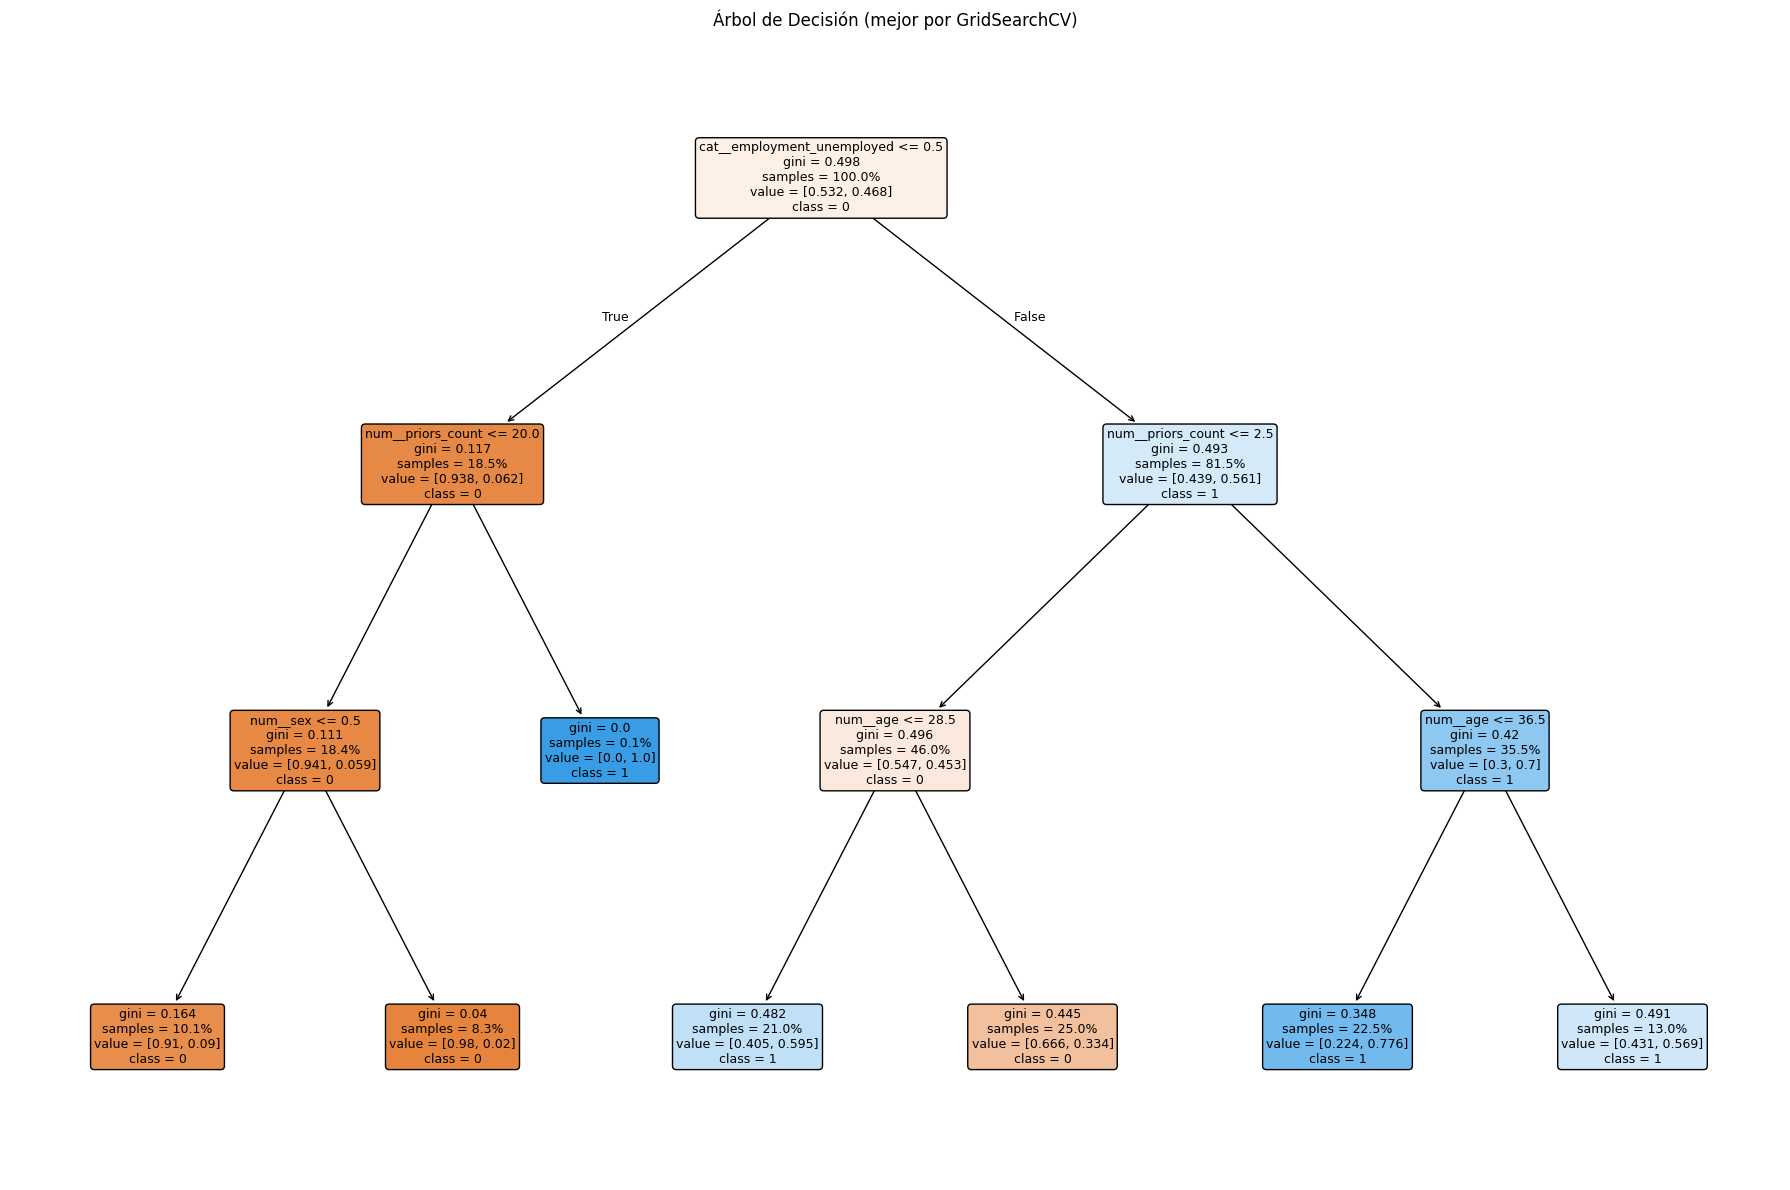

In [8]:
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt
import numpy as np

best_dt = best_clf.named_steps["dt"]

# Nombres de features tras el preprocesado
feature_names_out = best_clf.named_steps["prep"].get_feature_names_out(X.columns)

# Reglas en texto
print(export_text(best_dt, feature_names=list(feature_names_out)))

# Plot
classes_ = getattr(best_dt, "classes_", np.unique(y_train))
plt.figure(figsize=(18, 12))
plot_tree(
    best_dt,
    feature_names=feature_names_out,
    class_names=[str(c) for c in classes_],
    filled=True, rounded=True, impurity=True, proportion=True, fontsize=9
)
plt.title("Árbol de Decisión (mejor por GridSearchCV)")
plt.tight_layout()
plt.show()


## Mostrar explicabilidad

In [17]:
import numpy as np

def explain_instance_path(pipeline, x_row_df, num_cols, cat_cols, y_classes=None):
    """
    pipeline: tu Pipeline (prep + dt)
    x_row_df: DataFrame con UNA sola fila de X (usa X_test.iloc[[idx]])
    num_cols, cat_cols: listas usadas en tu ColumnTransformer
    y_classes: opcional, clases del modelo para imprimir (si None, se obtienen de dt)
    """
    prep = pipeline.named_steps["prep"]
    dt   = pipeline.named_steps["dt"]

    # 1) Transformar esa fila como en inferencia
    Xt = prep.transform(x_row_df)            # shape (1, n_features_after_ohe)
    feature_names_out = prep.get_feature_names_out(x_row_df.columns)

    # 2) Construir un mapa robusto idx -> (tipo, nombre[, categoria])
    #    Sabemos que el ColumnTransformer tenía: ("num","passthrough", num_cols) y ("cat", OneHotEncoder, cat_cols)
    #    Así que primero van los num, luego las dummies OHE en el mismo orden que cat_cols.
    ohe = prep.named_transformers_["cat"]    # OneHotEncoder ya ajustado
    ohe_cats = ohe.categories_               # lista de arrays de categorías por columna categórica

    num_end = len(num_cols)                  # índices [0, num_end) son numéricas
    ohe_map = {}                             # idx -> (col, categoria)
    k = num_end
    for col_name, cats in zip(cat_cols, ohe_cats):
        for c in cats:
            ohe_map[k] = (col_name, c)
            k += 1

    # 3) Camino de decisión
    node_indicator = dt.decision_path(Xt)    # matriz dispersa (1, n_nodes)
    leaf_id = dt.apply(Xt)[0]
    node_index = node_indicator.indices      # nodos visitados por esa muestra

    # 4) Probabilidades y clase predicha
    proba = dt.predict_proba(Xt)[0]
    pred  = dt.predict(Xt)[0]
    if y_classes is None:
        y_classes = getattr(dt, "classes_", np.arange(len(proba)))

    print("=== EXPLICACIÓN INSTANCIA ===")
    print("Fila original (antes de OHE):")
    display(x_row_df)  # En Colab/Jupyter

    print("\nPredicción:", pred)
    print("Probabilidades por clase:")
    for cls, p in zip(y_classes, proba):
        print(f"  P(y={cls}) = {p:.4f}")

    print("\nCamino por el árbol (condiciones en cada nodo):")

    for node_id in node_index:
        # Si es hoja, no hay condición (feature = -2)
        feature_id = dt.tree_.feature[node_id]
        threshold  = dt.tree_.threshold[node_id]
        if feature_id == -2:
            continue

        fname = feature_names_out[feature_id]
        x_val = Xt[0, feature_id]

        # ¿Numérica u OHE?
        if feature_id < num_end:
            # Numérica
            cond_true = x_val <= threshold
            sign = "<=" if cond_true else ">"
            print(f"- [{node_id}] {fname} ({x_val:.4f}) {sign} {threshold:.4f}")
        else:
            # One-Hot: suele comparar con 0.5; x_val es 0/1
            col, cat = ohe_map[feature_id]
            # En árboles binarios, la forma típica: (dummy <= 0.5) significa "NO es esa categoría"
            if x_val <= threshold:  # normalmente threshold ~ 0.5
                print(f"- [{node_id}] {col} != '{cat}' (dummy={x_val:.0f} <= {threshold:.1f})")
            else:
                print(f"- [{node_id}] {col} == '{cat}' (dummy={x_val:.0f} > {threshold:.1f})")

    print(f"\nHoja alcanzada: node_id={leaf_id}")
    n_node_samples = dt.tree_.n_node_samples[leaf_id]
    impurity = dt.tree_.impurity[leaf_id]
    print(f"Muestras en la hoja: {n_node_samples}, Impureza (Gini/Entropy): {impurity:.4f}")

In [18]:
# === Ejemplo de uso con una fila concreta del set de test ===
idx = 1  # cambia el índice que quieras inspeccionar
x_row_df = X_test.iloc[[idx]]
explain_instance_path(best_clf, x_row_df, num_cols=num_cols, cat_cols=cat_cols)


=== EXPLICACIÓN INSTANCIA ===
Fila original (antes de OHE):


,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_African-American,race_Caucasian,c_charge_degree_F,c_charge_degree_M,employment
1535,1,44,0,0,0,2,0,1,0,1,unemployed



Predicción: 0
Probabilidades por clase:
  P(y=0) = 0.6658
  P(y=1) = 0.3342

Camino por el árbol (condiciones en cada nodo):
- [0] employment == 'unemployed' (dummy=1 > 0.5)
- [6] num__priors_count (2.0000) <= 2.5000
- [7] num__age (44.0000) > 28.5000

Hoja alcanzada: node_id=9
Muestras en la hoja: 739, Impureza (Gini/Entropy): 0.4450


# Decision Tree Classifier con profundidad

In [ ]:
# Pipeline: preprocesamiento + modelo (limitando el árbol)
clf = Pipeline(steps=[
    ("prep", preprocess),
    ("dt", DecisionTreeClassifier(criterion="gini",
    max_depth=4,
    min_samples_leaf=5,
    random_state=42))
])

In [ ]:
# Entrenar
clf.fit(X_train, y_train)

# Evaluar
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (valid): {acc:.4f}\n")

print("== Classification report (valid) ==")
print(classification_report(y_test, y_pred))

print("== Confusion matrix (valid) ==")
print(confusion_matrix(y_test, y_pred))

Accuracy (valid): 0.7136

== Classification report (valid) ==
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       449
           1       0.67      0.76      0.71       396

    accuracy                           0.71       845
   macro avg       0.72      0.72      0.71       845
weighted avg       0.72      0.71      0.71       845

== Confusion matrix (valid) ==
[[304 145]
 [ 97 299]]


In [ ]:
# Asumiendo que ya tienes entrenado el árbol en 'model'
# Access the DecisionTreeClassifier from the pipeline
decision_tree_model = clf.named_steps['dt']

# Get feature names after preprocessing
# This requires fitting the preprocessor separately or getting feature names from the pipeline
# For simplicity, let's use the original feature names for now, but be aware of one-hot encoding
# A more robust solution would involve getting feature names from the preprocessor after fitting

# Get feature names from the preprocessor after fitting
# This is a bit more complex because OneHotEncoder changes the feature names
# A simpler approach for visualization might be to use the original feature names
# but the visualization won't reflect the one-hot encoded features

# Let's use the feature names from the fitted preprocessor
try:
    # This works for newer versions of scikit-learn
    feature_names_out = clf.named_steps['prep'].get_feature_names_out(X.columns)
except AttributeError:
    # Fallback for older versions - might not be perfect
    feature_names_out = list(X.columns)


rules = export_text(decision_tree_model, feature_names=list(feature_names_out))
print(rules)

|--- cat__employment_unemployed <= 0.50
|   |--- num__priors_count <= 20.00
|   |   |--- num__sex <= 0.50
|   |   |   |--- num__priors_count <= 2.50
|   |   |   |   |--- num__age <= 21.50
|   |   |   |   |   |--- num__c_charge_degree_M <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- num__c_charge_degree_M >  0.50
|   |   |   |   |   |   |--- num__priors_count <= 0.50
|   |   |   |   |   |   |   |--- num__race_Caucasian <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- num__race_Caucasian >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- num__priors_count >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- num__age >  21.50
|   |   |   |   |   |--- num__c_charge_degree_F <= 0.50
|   |   |   |   |   |   |--- num__age <= 62.00
|   |   |   |   |   |   |   |--- num__age <= 40.50
|   |   |   |   |   |   |   |   |--- num__age <= 27.50
|   |   |   |   |   |   |   |   |   |--- num__ag

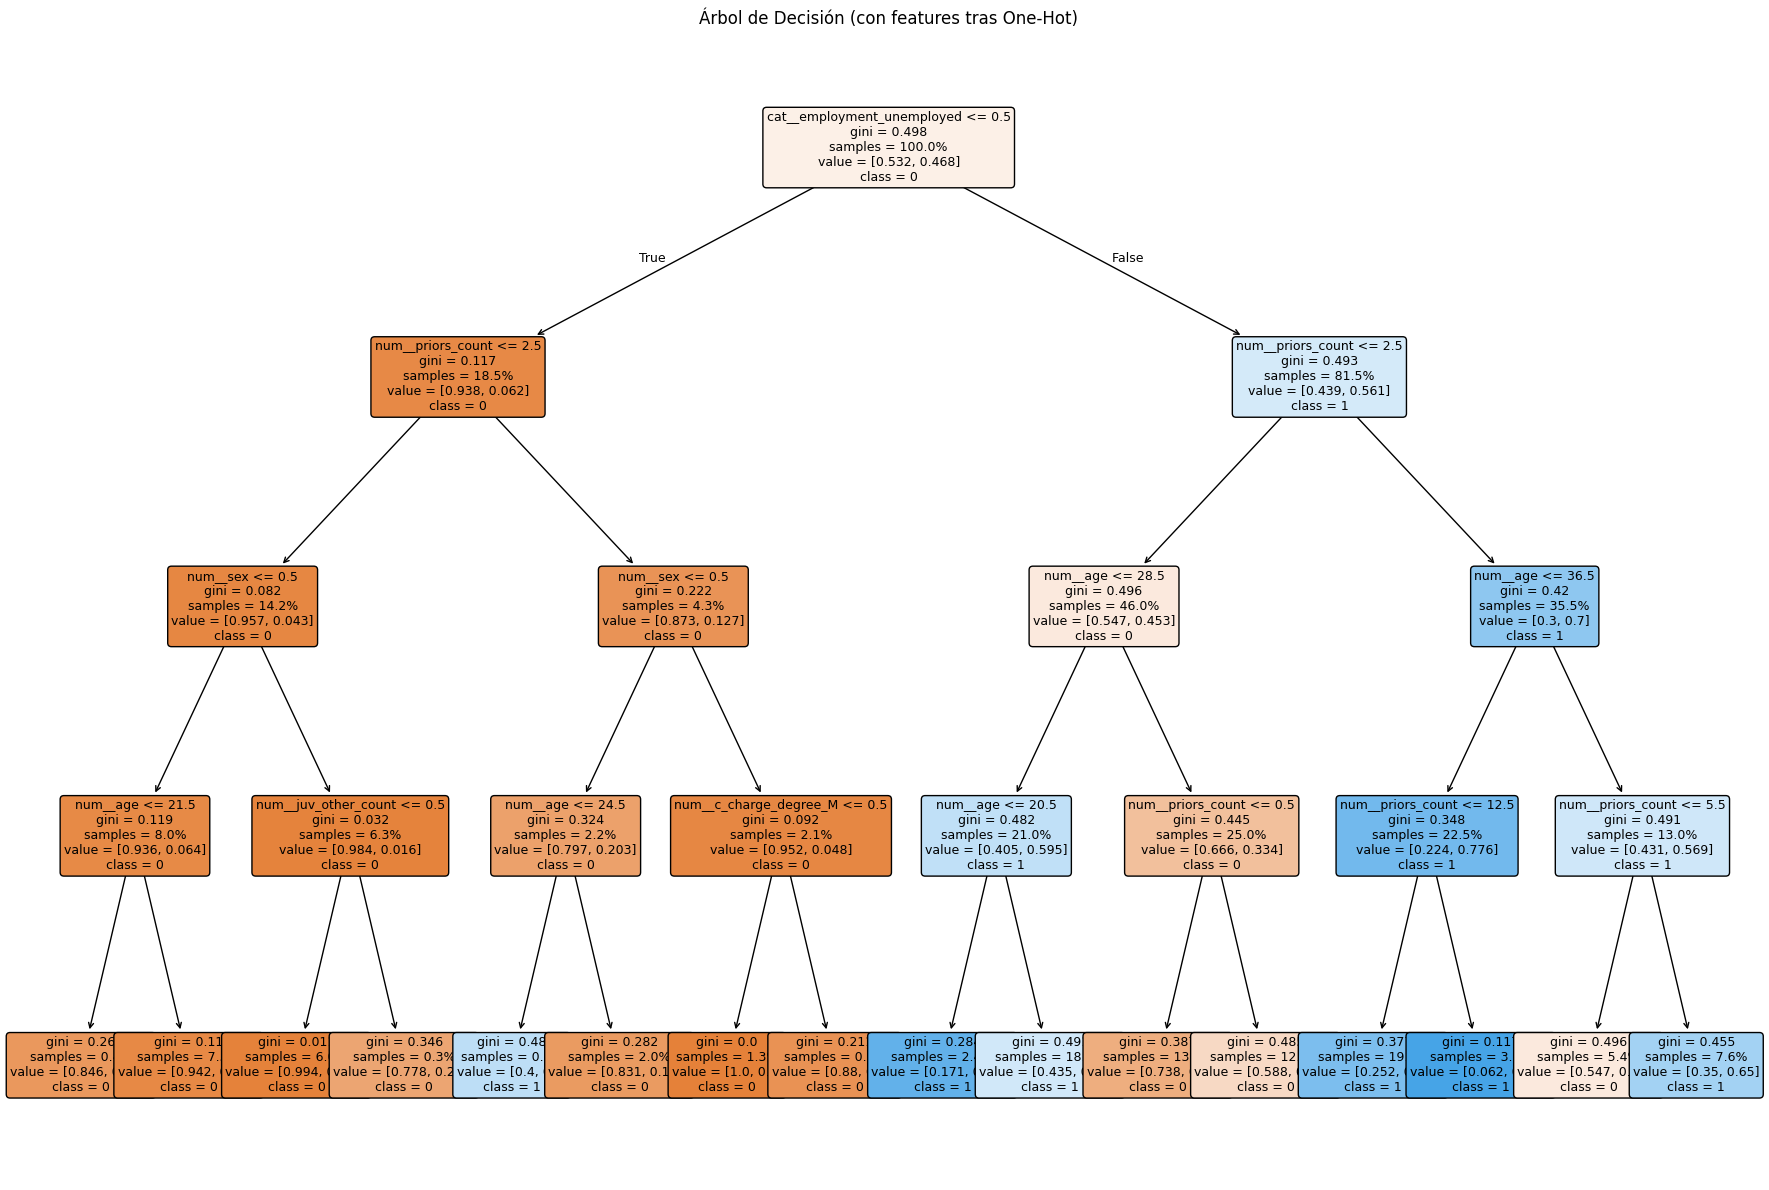

In [ ]:
# Aseguramos nombres de clase legibles (en el mismo orden que usa el modelo)
classes_ = getattr(decision_tree_model, "classes_", None)
if classes_ is None:
    # fallback por si acaso
    classes_ = np.unique(y_train)

plt.figure(figsize=(18, 12))
plot_tree(
    decision_tree_model,
    feature_names=feature_names_out,        # nombres tras One-Hot/ColumnTransformer
    class_names=[str(c) for c in classes_], # etiquetas de clase
    filled=True,
    rounded=True,
    impurity=True,      # gini/entropy en nodos (puedes poner False si lo quieres más limpio)
    proportion=True,    # muestra proporción de muestras por nodo
    fontsize=9
)
plt.title("Árbol de Decisión (con features tras One-Hot)")
plt.tight_layout()
plt.show()
